In [1]:
import os
import sys

# Set the parent folder (of operator_learning) as the working directory and home for imports
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(parent_dir)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


In [2]:
from godunov_solver.solve_class import *

nx = 200
nt = 500
dx = 0.25
dt = 0.05
bc = "GhostCell"
ic = "RiemannProblem"
grid = Grid(nx, nt, dx, dt, ic, bc, uL=0.2, uR=0.3, step=50)
solver = GodunovLWR(flux=GreenshieldsFlux(vmax=1.0, rho_max=1.0))
solver.solve(grid)


In [3]:
#import torch Dataset
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

def gen_grid(solver, nx, nt, dx, dt, bc):
    ic = "PiecewiseConstant"
    # Random number of steps
    n_steps = np.random.randint(1, 10)

    # Random values of steps
    steps = sorted(np.random.randint(0, nx, size=n_steps))

    # Random v for each step, between 0 and 1
    values = np.random.rand(n_steps)

    grid = Grid(nx, nt, dx, dt, ic, bc, values=values, steps=steps)
    solver.solve(grid)
    return grid.grid['h']
    
    

class GridDataset(Dataset):
    def __init__(self, n_samples, nx, nt, dx, dt, bc, **kwargs):
        self.n_samples = n_samples
        self.bc = bc
        solver = GodunovLWR(flux=GreenshieldsFlux(vmax=1.0, rho_max=1.0))
        self.grids = []
        for _ in tqdm(range(n_samples), desc="Generating grids"):
            self.grids.append(gen_grid(solver, nx, nt, dx, dt, bc))

    def __len__(self):
        return len(self.grids)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.grids[idx]).to(torch.float32).unsqueeze(-1)

dataset = GridDataset(n_samples=100, nx=nx, nt=nt, dx=dx, dt=dt, bc="GhostCell")


Generating grids: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


In [4]:
from torch.utils.data import DataLoader
from neuralop.models import FNO
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import math
import random

def _stack_time_window(win):  # win: (B, T, nx, C) -> (B, nx, T*C)
    B, T, nx, C = win.shape
    return win.permute(0, 2, 1, 3).reshape(B, nx, T * C)

def train_autoreg_epoch(
    model,
    loader: DataLoader,     # yields batches u: (B, nt, nx, C)
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    T: int,                 # history length
    teach_prob: float = 0.3,# scheduled sampling prob of using ground truth
    add_coord: bool = True, # append x \in [0,1] as a channel
    clip_grad: float | None = None,
    loss_fn = nn.MSELoss(reduction="mean"),
):
    model.train()
    running_loss = 0.0
    n_batches = 0

    for u in loader:
        # u: (B, nt, nx, C)
        u = u.to(device)
        B, nt, nx, C = u.shape
        assert nt > T, "nt must be greater than the history length T."

        # Precompute coordinate channel if desired: (B, nx, 1)
        if add_coord:
            xcoord = torch.linspace(0.0, 1.0, nx, device=device)[:, None]  # (nx,1)
            xcoord = xcoord.expand(nx, 1).unsqueeze(0).expand(B, nx, 1)    # (B,nx,1)

        # Rolling window initialized with first T frames
        # win: (B, T, nx, C)
        win = u[:, :T, :, :].clone()

        total_loss = 0.0
        n_steps = 0

        optimizer.zero_grad(set_to_none=True)

        # Autoregressive rollout across time: predict u_{t} from last T frames
        for t in range(T, nt):
            # Build model input: stack window along channels -> (B, nx, T*C)
            x_in = _stack_time_window(win)  # (B, nx, T*C)

            # Optionally append coordinates: (B, nx, T*C+1)
            if add_coord:
                x_in = torch.cat([x_in, xcoord], dim=-1)

            # Predict next frame
            # Expect model: (B, nx, Cin) -> (B, nx, C)
            # x_in is (B, nx, C_in) at this point
            x_in_cf = x_in.permute(0, 2, 1)     # -> (B, C_in, nx)

            pred_cf = model(x_in_cf)            # model expects (B, C_in, nx), returns (B, C, nx)
            pred = pred_cf.permute(0, 2, 1)     # -> (B, nx, C) to match your target

            # Ground truth for this step
            target = u[:, t, :, :]  # (B, nx, C)

            # Loss for this step
            loss_t = loss_fn(pred, target)
            total_loss = total_loss + loss_t
            n_steps += 1

            # Scheduled sampling: decide what to feed back
            use_teacher = (random.random() < teach_prob)
            next_in = target if use_teacher else pred.detach()  # detach keeps memory in check

            # Update rolling window: drop oldest, append next_in
            # win: (B, T, nx, C)
            if T > 1:
                win = torch.cat([win[:, 1:], next_in.unsqueeze(1)], dim=1)  # shift + append
            else:
                win = next_in.unsqueeze(1)

        # Backprop across the accumulated per-step loss (averaged)
        loss = total_loss / max(1, n_steps)
        loss.backward()

        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    return running_loss / max(1, n_batches)


In [5]:
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

history_len = 10
device = torch.device('mps')

model = FNO(
    n_modes=(32,),      # modes kept in each spatial dim
    hidden_channels=64,    # width
    in_channels=1 * history_len + 1,         # your per-point features (e.g., forcing + boundary flag)
    out_channels=1         # predicted field (e.g., solution)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_autoreg_epoch(model, dataloader, optimizer, device, history_len)

0.13915811106562614

In [6]:
from tqdm import tqdm

def train_model(model, dataloader, epochs, optimizer, device, history_len):
    for epoch in tqdm(range(epochs)):
        loss = train_autoreg_epoch(model, dataloader, optimizer, device, history_len)
        print(f"Epoch {epoch+1} loss: {loss}")

train_model(model, dataloader, 50, optimizer, device, history_len)

  2%|▏         | 1/50 [00:33<27:34, 33.76s/it]

Epoch 1 loss: 0.10013748854398727


  4%|▍         | 2/50 [01:05<26:03, 32.57s/it]

Epoch 2 loss: 0.08065072409808635


  6%|▌         | 3/50 [01:41<26:34, 33.93s/it]

Epoch 3 loss: 0.08378124386072158


  8%|▊         | 4/50 [02:16<26:23, 34.42s/it]

Epoch 4 loss: 0.05143717415630818


 10%|█         | 5/50 [02:51<25:55, 34.56s/it]

Epoch 5 loss: 0.036038448102772236


 12%|█▏        | 6/50 [03:25<25:19, 34.54s/it]

Epoch 6 loss: 0.02803104892373085


 14%|█▍        | 7/50 [04:02<25:20, 35.36s/it]

Epoch 7 loss: 0.015858046337962152


 16%|█▌        | 8/50 [04:38<24:50, 35.49s/it]

Epoch 8 loss: 0.013069485547021031


 18%|█▊        | 9/50 [05:18<25:17, 37.00s/it]

Epoch 9 loss: 0.008151529682800173


 20%|██        | 10/50 [05:58<25:10, 37.76s/it]

Epoch 10 loss: 0.006990874093025923


 22%|██▏       | 11/50 [06:30<23:30, 36.18s/it]

Epoch 11 loss: 0.0045176912099123


 24%|██▍       | 12/50 [07:14<24:26, 38.59s/it]

Epoch 12 loss: 0.004109461978077889


 26%|██▌       | 13/50 [07:50<23:10, 37.59s/it]

Epoch 13 loss: 0.0035072910133749245


 28%|██▊       | 14/50 [08:35<24:00, 40.02s/it]

Epoch 14 loss: 0.002850754524115473


 30%|███       | 15/50 [09:16<23:26, 40.18s/it]

Epoch 15 loss: 0.0032144139404408634


 32%|███▏      | 16/50 [09:56<22:50, 40.31s/it]

Epoch 16 loss: 0.003569556924048811


 34%|███▍      | 17/50 [10:33<21:35, 39.25s/it]

Epoch 17 loss: 0.0032216892926953734


 36%|███▌      | 18/50 [11:14<21:10, 39.70s/it]

Epoch 18 loss: 0.002313399373088032


 38%|███▊      | 19/50 [12:00<21:29, 41.61s/it]

Epoch 19 loss: 0.0018668183940462769


 40%|████      | 20/50 [12:45<21:18, 42.61s/it]

Epoch 20 loss: 0.001767797884531319


 42%|████▏     | 21/50 [13:23<19:52, 41.11s/it]

Epoch 21 loss: 0.0016244169790297746


 44%|████▍     | 22/50 [13:56<18:09, 38.92s/it]

Epoch 22 loss: 0.0016460508573800325


 46%|████▌     | 23/50 [14:34<17:21, 38.57s/it]

Epoch 23 loss: 0.0014895857078954578


 48%|████▊     | 24/50 [15:08<16:08, 37.23s/it]

Epoch 24 loss: 0.0014603345945943147


 50%|█████     | 25/50 [15:50<16:01, 38.46s/it]

Epoch 25 loss: 0.0015112914610654117


 52%|█████▏    | 26/50 [16:34<16:03, 40.17s/it]

Epoch 26 loss: 0.0012951623997651041


 54%|█████▍    | 27/50 [17:14<15:22, 40.12s/it]

Epoch 27 loss: 0.0014548169681802392


 56%|█████▌    | 28/50 [17:54<14:42, 40.09s/it]

Epoch 28 loss: 0.0013884020561818033


 58%|█████▊    | 29/50 [18:45<15:15, 43.58s/it]

Epoch 29 loss: 0.0014062984497286378


 60%|██████    | 30/50 [19:41<15:43, 47.17s/it]

Epoch 30 loss: 0.001240526873152703


 62%|██████▏   | 31/50 [20:37<15:47, 49.88s/it]

Epoch 31 loss: 0.0011710681079421192


 64%|██████▍   | 32/50 [21:16<13:59, 46.64s/it]

Epoch 32 loss: 0.001210448273923248


 66%|██████▌   | 33/50 [21:58<12:48, 45.20s/it]

Epoch 33 loss: 0.0010698781523387879


 68%|██████▊   | 34/50 [22:35<11:24, 42.76s/it]

Epoch 34 loss: 0.001056910736951977


 70%|███████   | 35/50 [23:19<10:46, 43.07s/it]

Epoch 35 loss: 0.0010632484103552998


 72%|███████▏  | 36/50 [24:01<10:00, 42.87s/it]

Epoch 36 loss: 0.0009543536347337067


 74%|███████▍  | 37/50 [24:42<09:07, 42.10s/it]

Epoch 37 loss: 0.0009320125856902451


 76%|███████▌  | 38/50 [25:18<08:05, 40.47s/it]

Epoch 38 loss: 0.0009276190015953034


 78%|███████▊  | 39/50 [25:55<07:12, 39.36s/it]

Epoch 39 loss: 0.0008416466298513114


 80%|████████  | 40/50 [26:47<07:11, 43.11s/it]

Epoch 40 loss: 0.0008623199828434736


 82%|████████▏ | 41/50 [27:27<06:20, 42.22s/it]

Epoch 41 loss: 0.0008573417784646153


 84%|████████▍ | 42/50 [28:11<05:42, 42.79s/it]

Epoch 42 loss: 0.0008926895214244723


 86%|████████▌ | 43/50 [28:56<05:04, 43.47s/it]

Epoch 43 loss: 0.00091721010976471


 88%|████████▊ | 44/50 [29:38<04:17, 42.90s/it]

Epoch 44 loss: 0.0009658198861870915


 90%|█████████ | 45/50 [30:20<03:32, 42.55s/it]

Epoch 45 loss: 0.0008736641146242618


 92%|█████████▏| 46/50 [31:02<02:50, 42.53s/it]

Epoch 46 loss: 0.000832329026889056


 94%|█████████▍| 47/50 [31:41<02:04, 41.43s/it]

Epoch 47 loss: 0.0007477896637283265


 96%|█████████▌| 48/50 [32:28<01:26, 43.04s/it]

Epoch 48 loss: 0.0008106505265459418


 98%|█████████▊| 49/50 [33:09<00:42, 42.38s/it]

Epoch 49 loss: 0.0007864905055612326


100%|██████████| 50/50 [33:49<00:00, 40.60s/it]

Epoch 50 loss: 0.0007699793874053285


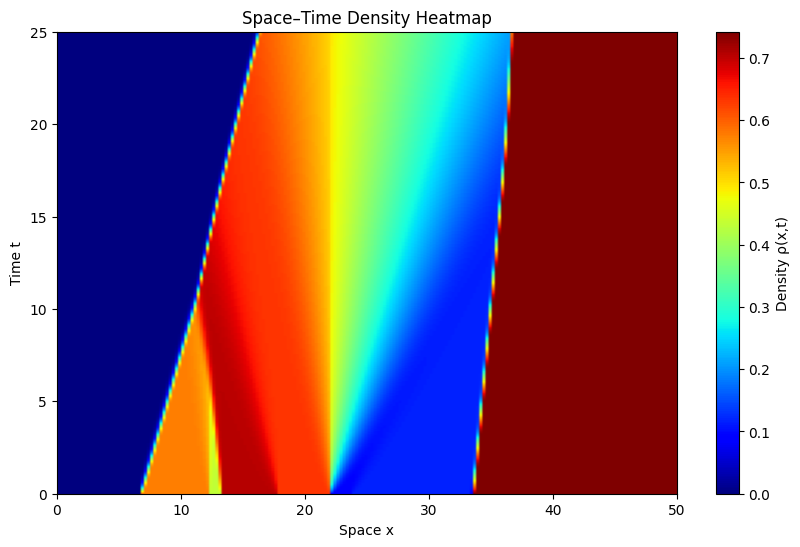

In [7]:
from godunov_solver.plotter import plot_grid_density

plot_grid_density(dataset[1], nx, nt, dx, dt)

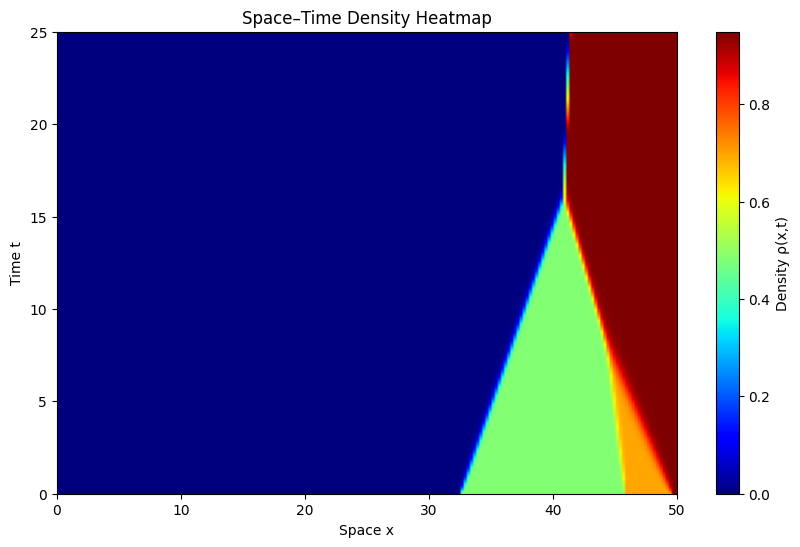

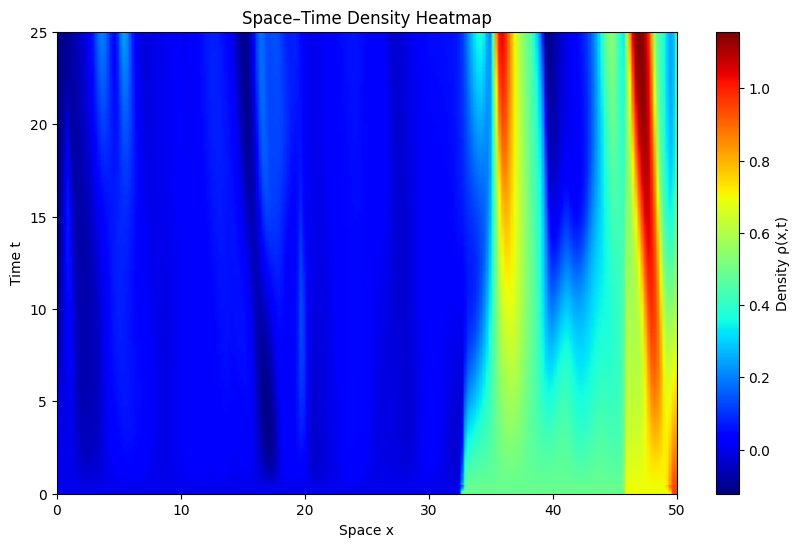

In [ ]:
def autoreg_rollout(model, u, T, add_coord=True):
    """
    u:   (B, nt, nx, C) full ground truth grid (only first T steps used)
    T:   history length
    out: (B, nt, nx, C) full predicted rollout
    """
    model.eval()
    with torch.no_grad():
        u = u.clone()
        B, nt, nx, C = u.shape
        
        # result buffer filled with zeros, we will fill all timesteps
        out = torch.zeros_like(u)

        # copy the first T truth steps
        out[:, :T] = u[:, :T]

        # build coordinate channel if needed
        if add_coord:
            x = torch.linspace(0, 1, nx, device=u.device)[None, :, None]  # (1, nx, 1)
            x = x.expand(B, nx, 1)  # (B, nx, 1)

        # rolling time window (B, T, nx, C)
        win = out[:, :T].clone()

        for t in range(T, nt):
            # --- build model input ---
            # Stack window: (B, T, nx, C) -> (B, nx, T*C)
            B_, T_, nx_, C_ = win.shape
            x_in = win.permute(0, 2, 1, 3).reshape(B, nx, T * C)

            # append coordinate channel if desired
            if add_coord:
                x_in = torch.cat([x_in, x], dim=-1)     # (B, nx, T*C+1)

            # permute to channels-first for FNO
            x_in_cf = x_in.permute(0, 2, 1)            # (B, C_in, nx)

            # --- predict next frame ---
            pred_cf = model(x_in_cf)                   # (B, C, nx)
            pred = pred_cf.permute(0, 2, 1)            # (B, nx, C)

            # write prediction into output buffer
            out[:, t] = pred

            # update window: drop oldest, append prediction
            if T > 1:
                win = torch.cat([win[:, 1:], pred.unsqueeze(1)], dim=1)
            else:
                win = pred.unsqueeze(1)

        return out

pred = autoreg_rollout(model, dataset[2].unsqueeze(0).to(device), history_len)
plot_grid_density(dataset[2], nx, nt, dx, dt)
plot_grid_density(pred[0].cpu().numpy(), nx, nt, dx, dt)